In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from fancyimpute import IterativeImputer
#pip install fancyimpute beforehand if u've never used it

from sklearn.preprocessing import LabelEncoder

from scipy import stats
from scipy.stats import norm, skew

In [3]:
train = pd.read_csv('/Users/apple/Documents/!data analysis/Kaggle/train HPr.csv')
test = pd.read_csv('/Users/apple/Documents/!data analysis/Kaggle/test HPr.csv')

In [4]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [6]:
print("train size before droping Id: {}".format(train.shape))
print("test size before droping Id: {}".format(test.shape))

#save id
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True) #True means it doesn't do a copy
test.drop(['Id'], axis=1, inplace=True)

print("train size afterwards: {}".format(train.shape))
print("test size afterwards: {}".format(test.shape))

train size before droping Id: (1460, 81)
test size before droping Id: (1459, 80)
train size afterwards: (1460, 80)
test size afterwards: (1459, 79)


"Note :

Outliers removal is note always safe. We decided to delete these two as they are very huge and really bad ( extremely large areas for very low prices).

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. You can refer to the modelling part of this notebook for that."

mu = 180921.20 and sigma = 79415.29


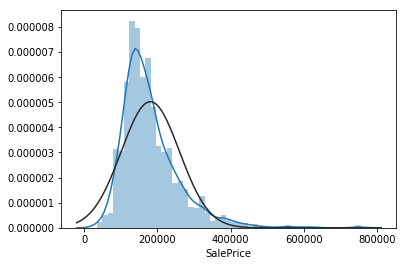

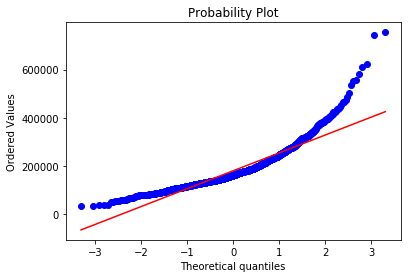

In [7]:
#Look at the target variable

sns.distplot(train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])
print("mu = {:.2f} and sigma = {:.2f}".format(mu, sigma))

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

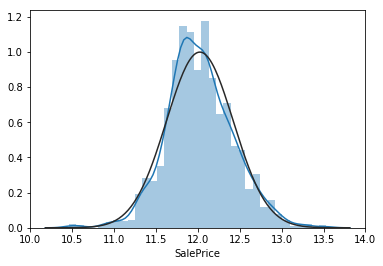

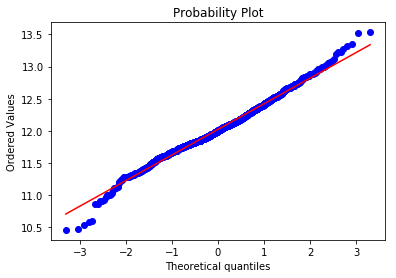

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [9]:
ntrain, mtrain = train.shape
ntest, mtest = test.shape

print("Total must be rows - {} cols - {}".format(ntrain+ntest, mtest))

Total must be rows - 2919 cols - 79


In [10]:
#Data concatination
y_train = train.SalePrice.values
data_all = pd.concat((train, test)).reset_index(drop=True)
data_all.drop(['SalePrice'], axis=1, inplace=True)
print("Data shape {}".format(data_all.shape))

Data shape (2919, 79)


In [11]:
data_all.isnull().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64

In [12]:
#Missing data
data_all_null = (data_all.isnull().sum() / len(data_all)) * 100 #% of nulls
data_all_null = data_all_null.drop(data_all_null[data_all_null==0].index).sort_values(ascending=False)
#drop where no nans
data_all_null = pd.DataFrame(data_all_null)
data_all_null

,0
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


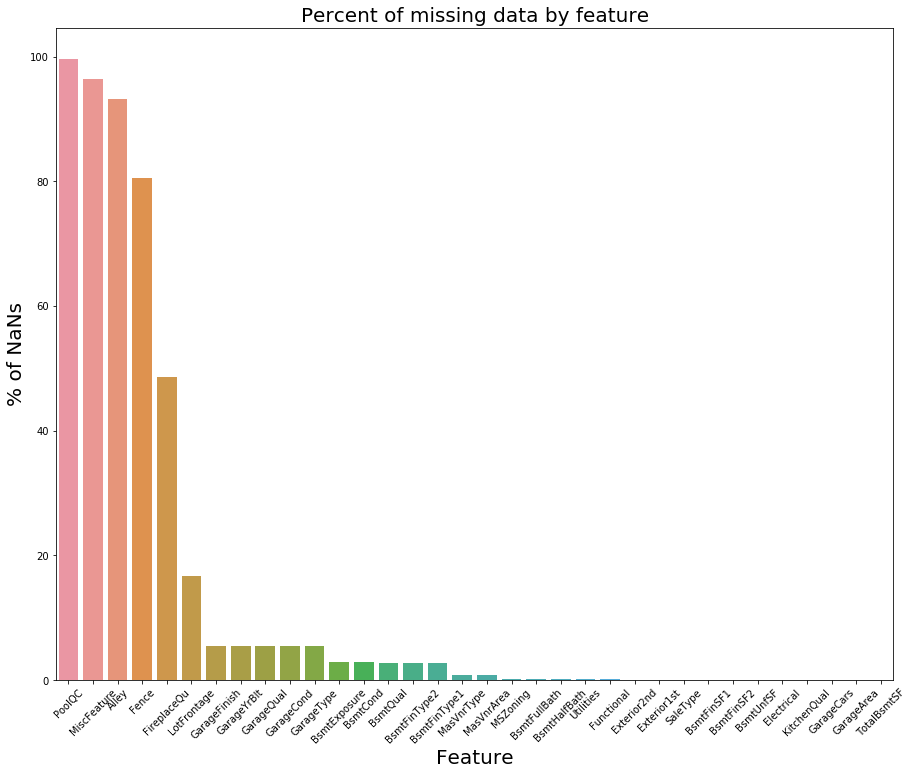

In [13]:
plt.subplots(figsize=(15,12))
sns.barplot(x=data_all_null.index, y=data_all_null.iloc[:,0])
plt.xticks(rotation=45)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('% of NaNs', fontsize=20)
plt.title('Percent of missing data by feature', fontsize=20)
plt.show()

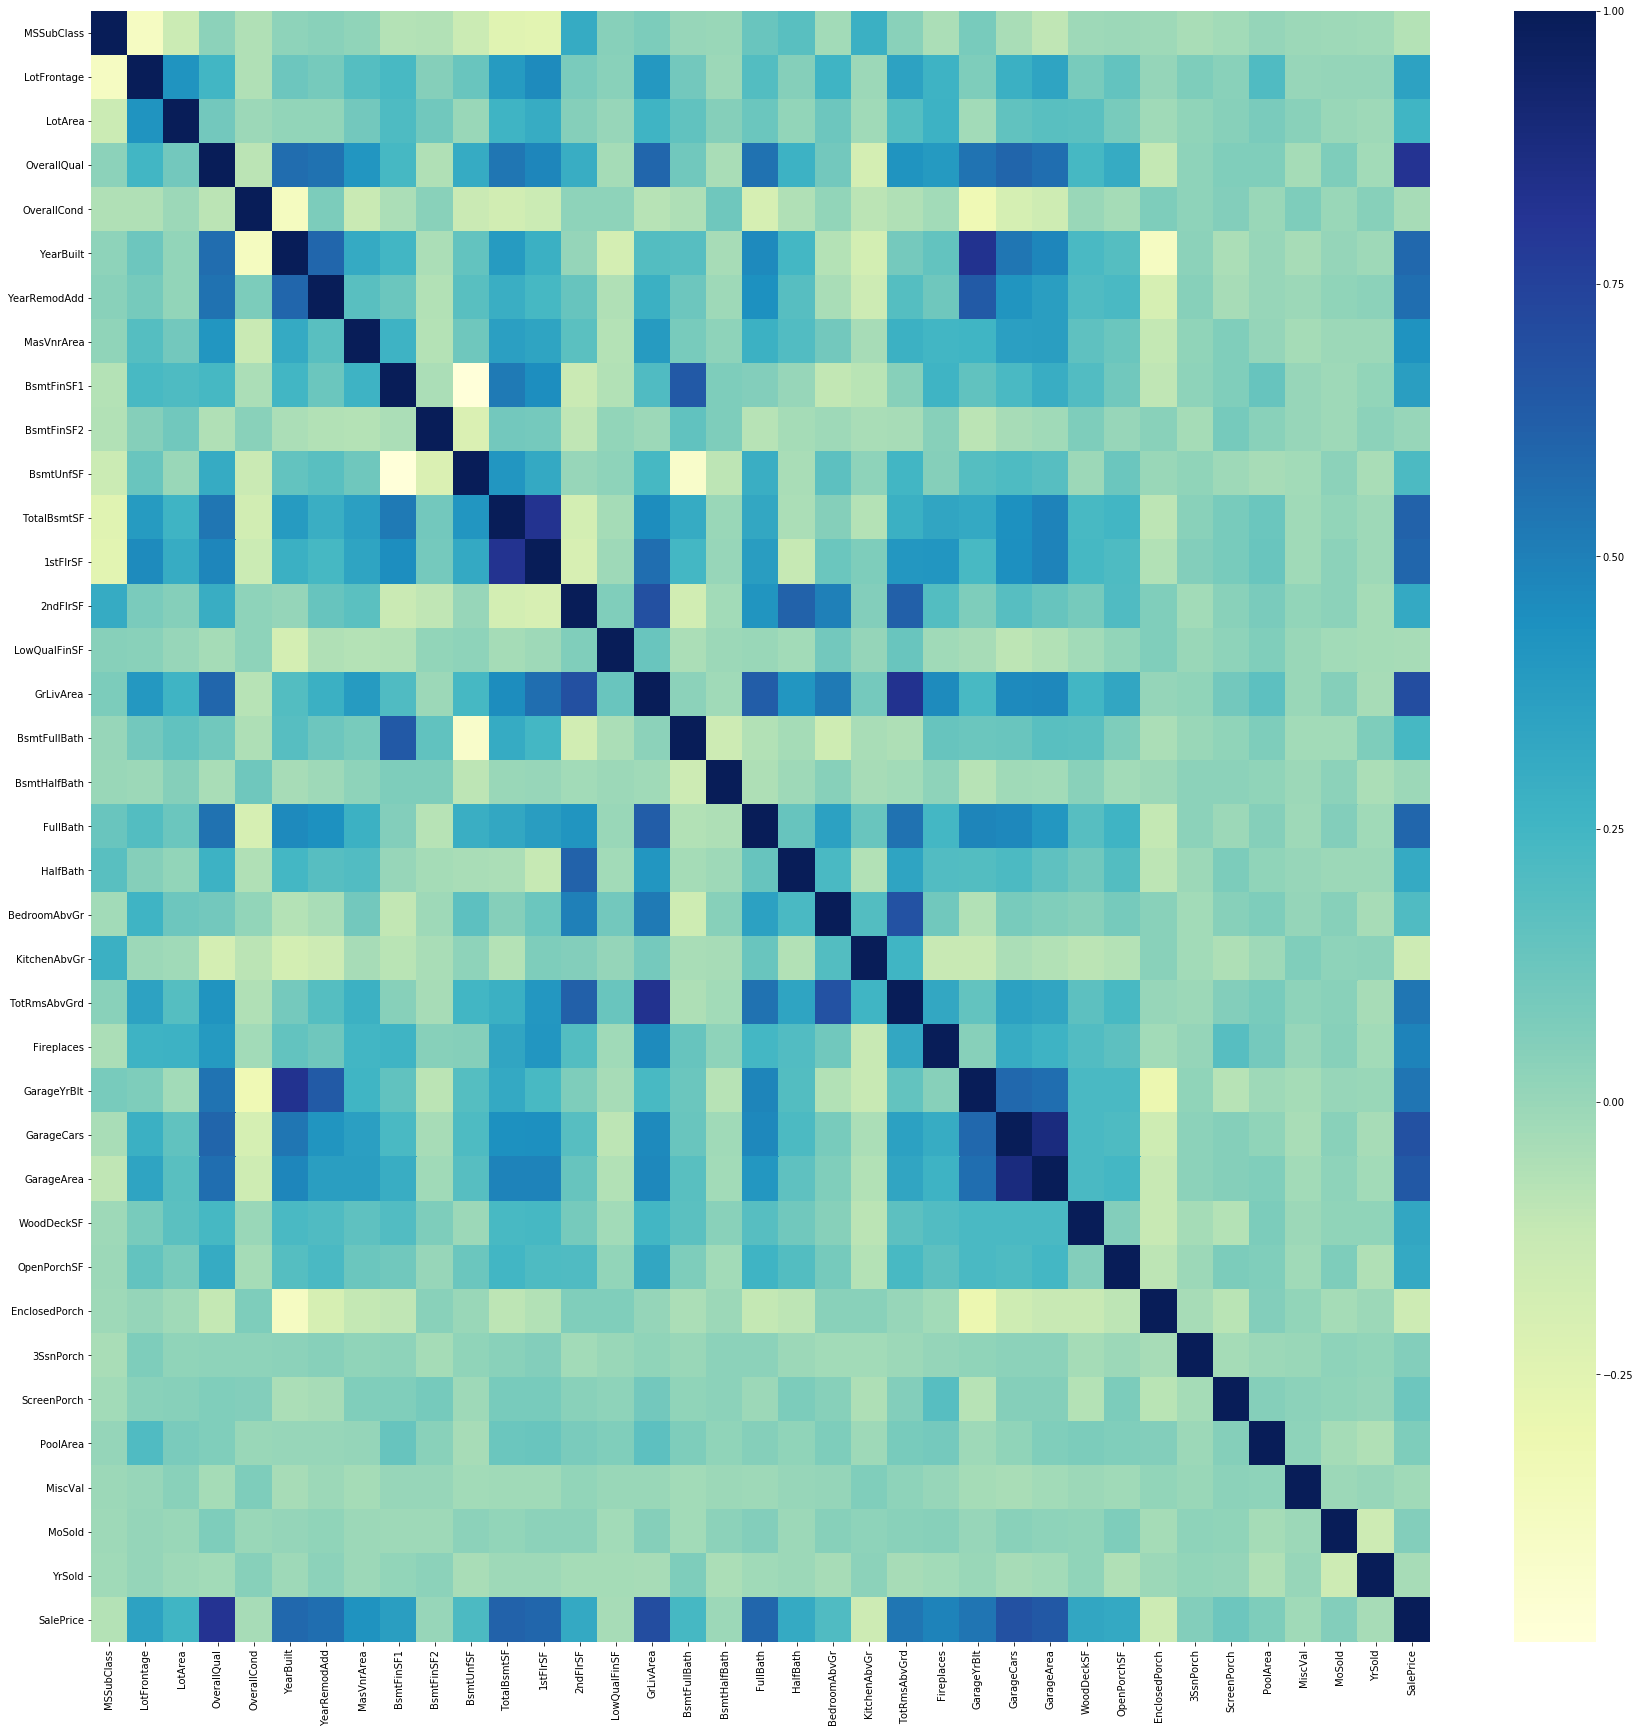

In [14]:
#Correlation with numeric features
corr = train.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corr, cmap='YlGnBu');

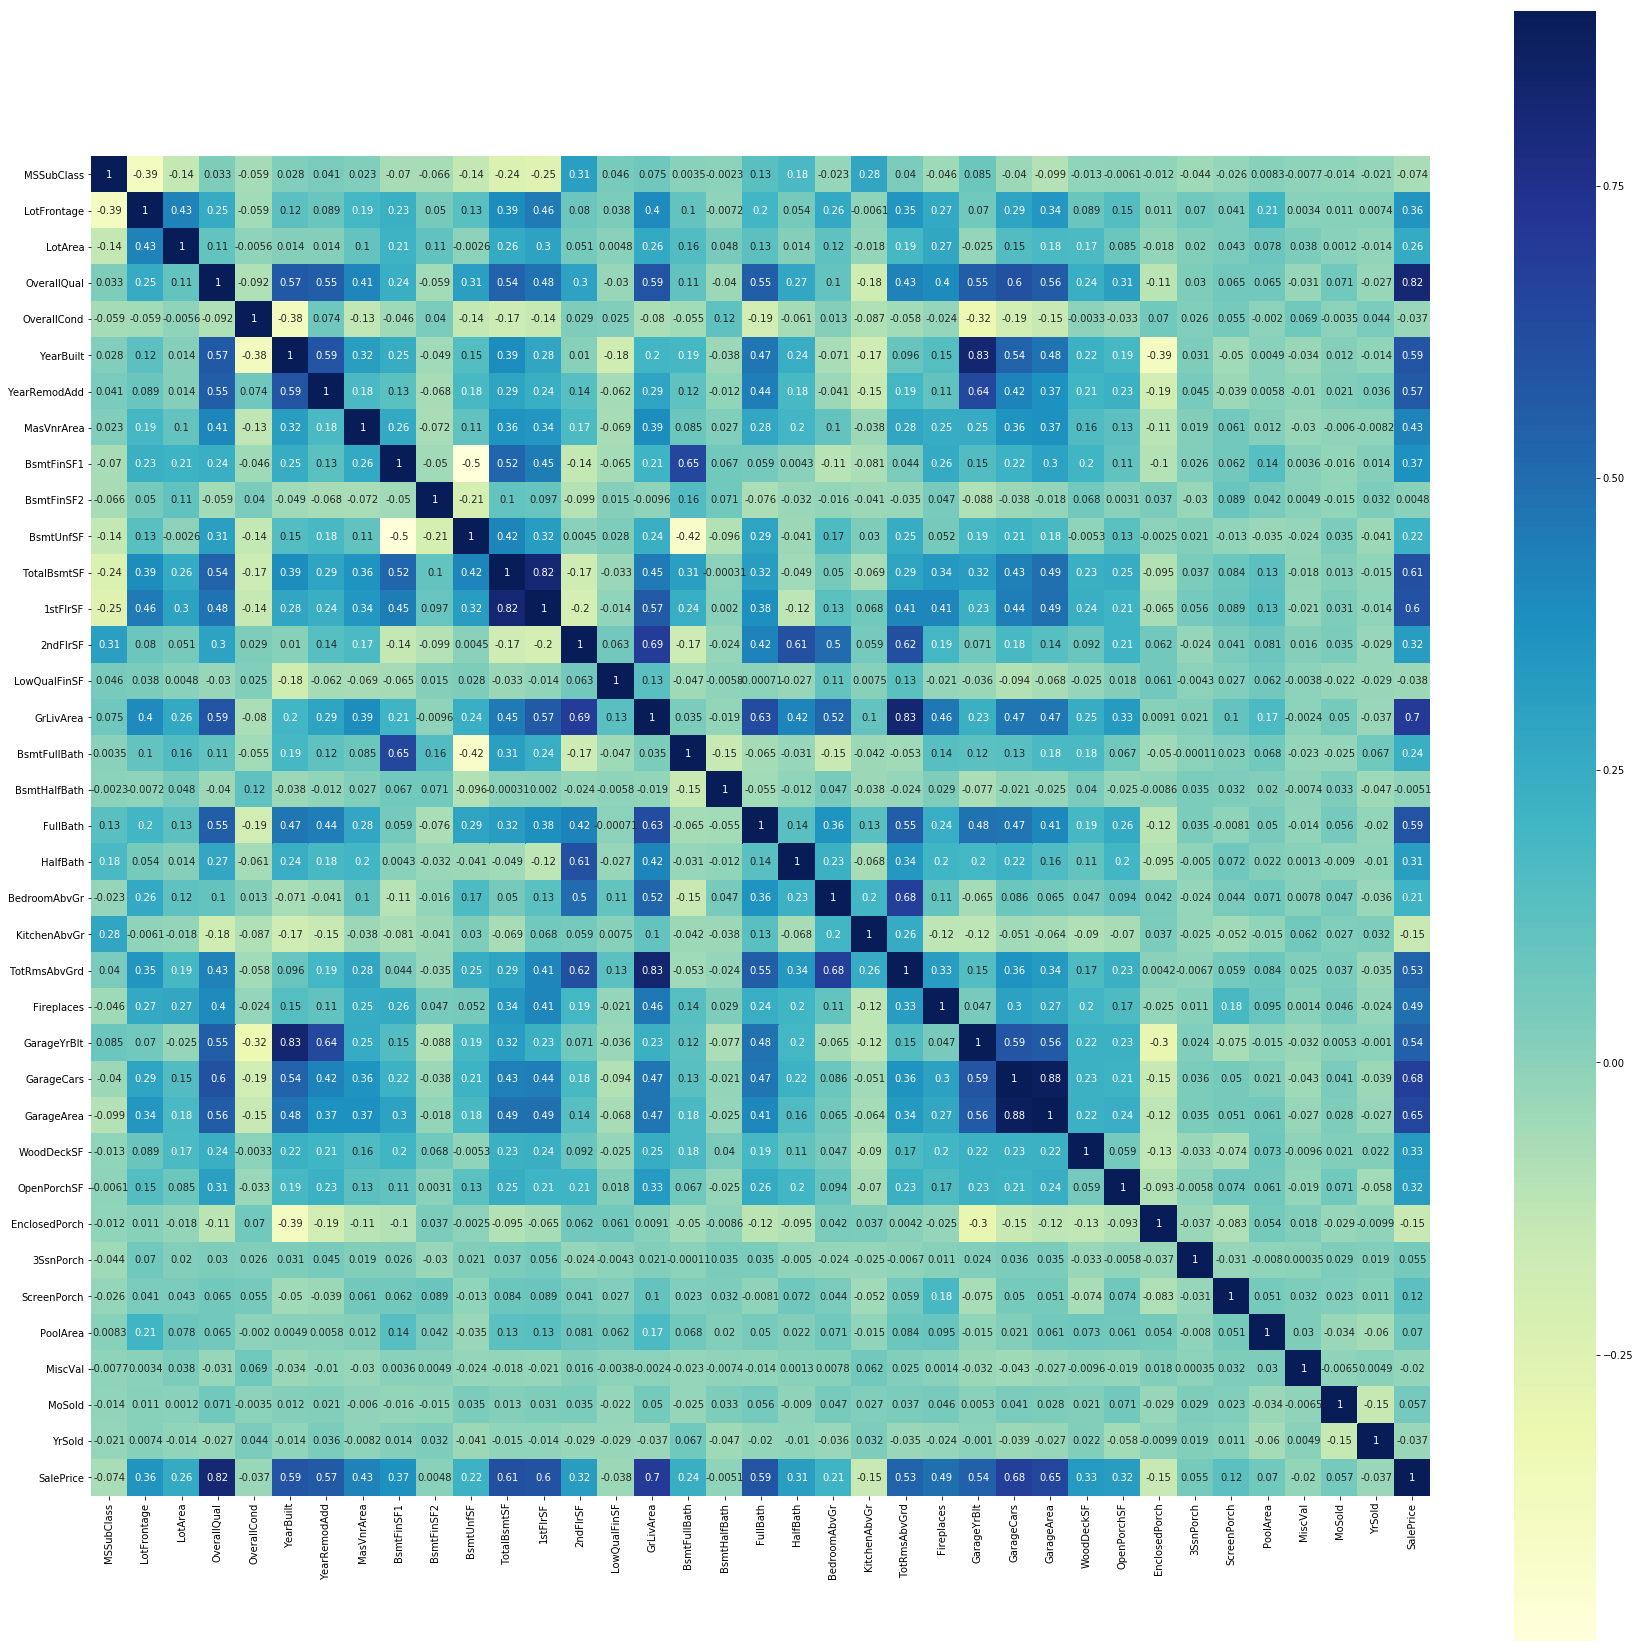

In [15]:
plt.subplots(figsize=(30,30))
sns.heatmap(corr, annot=True, vmax=0.9, square=True, cmap='YlGnBu');

In [16]:
#Filling nans. In accordabce with describtion if nan - the feature doesn't exists
data_all['PoolQC'] = data_all['PoolQC'].fillna('None')
data_all['MiscFeature'] = data_all['MiscFeature'].fillna('None')
data_all['Alley'] = data_all['Alley'].fillna('None')
data_all['Fence'] = data_all['Fence'].fillna('None')
data_all['FireplaceQu'] = data_all['FireplaceQu'].fillna('None')

Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood

In [17]:
data_all["LotFrontage"] = data_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [18]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_all[col] = data_all[col].fillna('None')

In [19]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'): #numeric cols
    data_all[col] = data_all[col].fillna(0)

In [20]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'): #numeric
    data_all[col] = data_all[col].fillna(0)

In [21]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'): #cateforic vars
    data_all[col] = data_all[col].fillna('None')

In [22]:
data_all["MasVnrType"] = data_all["MasVnrType"].fillna("None")
data_all["MasVnrArea"] = data_all["MasVnrArea"].fillna(0)

In [23]:
data_all['MSZoning'] = data_all['MSZoning'].fillna(data_all['MSZoning'].mode()[0])#no descr for none, fill with mode

In [24]:
data_all['Utilities'] = data_all['Utilities'].fillna(data_all['Utilities'].mode()[0])#no descr for none, fill with mode

In [25]:
#Home functionality (Assume typical unless deductions are warranted)
data_all["Functional"] = data_all["Functional"].fillna("Typ")

In [26]:
data_all['Electrical'] = data_all['Electrical'].fillna(data_all['Electrical'].mode()[0])

In [27]:
data_all['KitchenQual'] = data_all['KitchenQual'].fillna(data_all['KitchenQual'].mode()[0])

In [28]:
data_all['Exterior1st'] = data_all['Exterior1st'].fillna(data_all['Exterior1st'].mode()[0])
data_all['Exterior2nd'] = data_all['Exterior2nd'].fillna(data_all['Exterior2nd'].mode()[0])

In [29]:
data_all['SaleType'] = data_all['SaleType'].fillna(data_all['SaleType'].mode()[0])

In [30]:
data_all.isnull().any().any()
#val = data_all.isnull().any().to_frame().values
#key = data_all.isnull().any().to_frame().index
#dic = dict(zip(key,val))
#for k, v in dic.items():
    #if v==True:
       # print(k)

False

In [31]:
#find numerical data, whuch are truly categ
data_num = data_all.select_dtypes(include=[np.float, np.int])
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2919 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2919 non-null   float64
 8   BsmtFinSF1     2919 non-null   float64
 9   BsmtFinSF2     2919 non-null   float64
 10  BsmtUnfSF      2919 non-null   float64
 11  TotalBsmtSF    2919 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2919 non-null   float64
 17  BsmtHalfBath   2919 non-null   float64
 18  FullBath

In [34]:
# transform not-real numeric into categorical (years + MSSubClass(class coded) + ratings scales)
for col in ('MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'):
    data_all[col] = data_all[col].astype(str)

In [36]:
data_cat = data_all.select_dtypes(include=[np.object])
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     2919 non-null   object
 1   MSZoning       2919 non-null   object
 2   Street         2919 non-null   object
 3   Alley          2919 non-null   object
 4   LotShape       2919 non-null   object
 5   LandContour    2919 non-null   object
 6   Utilities      2919 non-null   object
 7   LotConfig      2919 non-null   object
 8   LandSlope      2919 non-null   object
 9   Neighborhood   2919 non-null   object
 10  Condition1     2919 non-null   object
 11  Condition2     2919 non-null   object
 12  BldgType       2919 non-null   object
 13  HouseStyle     2919 non-null   object
 14  OverallQual    2919 non-null   object
 15  OverallCond    2919 non-null   object
 16  YearBuilt      2919 non-null   object
 17  YearRemodAdd   2919 non-null   object
 18  RoofStyle      2919 non-null

In [40]:
#Label Encoding some categorical variables that may contain information in their ordering set
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'LandContour', 'LotConfig', 'HouseStyle', 'OverallQual', 
        'YearBuilt','YearRemodAdd', 'GarageYrBlt')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data_all[c].values)) 
    data_all[c] = lbl.transform(list(data_all[c].values))

# shape        
print('Shape all_data: {}'.format(data_all.shape))

Shape all_data: (2919, 79)


In [46]:
#check how skewed num vars are:
data_num = data_all.dtypes[data_all.dtypes != "object"].index
data_sk = data_all[data_num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print ("Skewed features:")
sk = pd.DataFrame({"Skewed" : data_sk})
print(sk.head(20))

Skewed features:
                  Skewed
MiscVal        21.947195
PoolArea       16.898328
LotArea        12.822431
LowQualFinSF   12.088761
3SsnPorch      11.376065
LandSlope       4.975157
KitchenAbvGr    4.302254
BsmtFinSF2      4.146143
EnclosedPorch   4.003891
ScreenPorch     3.946694
BsmtHalfBath    3.931594
MasVnrArea      2.613592
OpenPorchSF     2.535114
WoodDeckSF      1.842433
LotFrontage     1.505704
1stFlrSF        1.469604
BsmtFinSF1      1.425230
GrLivArea       1.269358
TotalBsmtSF     1.156894
BsmtUnfSF       0.919339


In [51]:
#We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x.
#Note that setting  λ=0 is equivalent to log1p used above for the target variable.
sk = sk[abs(sk) > 0.75]
print ("There are {} skewed numerical features to Box Cox transform".format(sk.shape[0]))

from scipy.special import boxcox1p
skewed_features = sk.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data_all[feat] = boxcox1p(data_all[feat], lam)

There are 61 skewed numerical features to Box Cox transform


In [52]:
#Getting dummys for categ which are not interrelatetd
data_all = pd.get_dummies(data_all)
print(data_all.shape)

(2919, 208)


In [54]:
#New sets
train = data_all[:ntrain]
test = data_all[ntrain:]

In [72]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [95]:
def cv_check(model):
    n_folds = 5
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
    return cross_val_score(model, train.values, y_train, cv=cv)

## Modelling

* LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [96]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

* Elastic Net Regression :
again made robust to outliers

In [97]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

* Kernel Ridge Regression :

In [98]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting Regression :
With **huber loss** that makes it robust to outliers

In [99]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* XGBoost :

In [100]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM:

In [101]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

CV check of performance. The less std is the better results are if mean is good =)

In [66]:
#Check the performance
print("Lasso performance - mean {}, std {}".format(cv_check(lasso).mean(), cv_check(lasso).std()))

Lasso performance - mean 0.8927127344847209, std 0.014722956374601998


In [67]:
print("Elastic Net performance - mean {}, std {}".format(cv_check(ENet).mean(), cv_check(ENet).std()))

Elastic Net performance - mean 0.892937861585267, std 0.015142429450660614


In [68]:
print("Kernel Ridge performance - mean {}, std {}".format(cv_check(KRR).mean(), cv_check(KRR).std()))

Kernel Ridge - mean 0.8834545600770409, std 0.017425943928523386


In [70]:
print("Gradient Boosting performance - mean {}, std {}".format(cv_check(GBoost).mean(), cv_check(GBoost).std()))

Gradient Boosting performance - mean 0.8970343718988515, std 0.007385420071474663


In [74]:
print("LightGBM performance - mean {}, std {}".format(cv_check(model_lgb).mean(), cv_check(model_lgb).std()))

LightGBM performance - mean 0.8967055480599564, std 0.00844508177940787


## Predictions

In [93]:
def for_subm(result, test_ID):
    result_id = np.c_[test_ID, result]
    result_df = pd.DataFrame(data=result_id, columns=["Id", "SalePrice"])
    result_df['Id'] = result_df['Id'].astype('int32')
    result_df.to_csv('result_reg.csv', index=False)

In [102]:
rb = RobustScaler()
train_trans = rb.fit_transform(train, y_train) 
test_trans = rb.fit_transform(test, y=None)
lasso.fit(train_trans, y_train)
lasso_prediction = lasso.predict(test_trans)

In [103]:
for_subm(lasso_prediction, test_ID)

In [88]:
model_xgb.fit(train, y_train)
xgb_prediction = model_xgb.predict(test)

[15:42:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [109]:
model_lgb.fit(train, y_train)
lgb_pred = model_lgb.predict(test)

In [113]:
#for_subm(pred_test_mix_ensemble, test_ID)

### Advanced Predictions

In [125]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [127]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

In [128]:
averaged_models

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                                    random_state=3))]),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5),
                        KernelRidge(alpha=0.6, coef0=2.5, degree=2,
                                    kernel='polynomial'),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                      

In [120]:
averaged_models.fit(train.values, y_train)
pred_train_mix = averaged_models.predict(train.values)
pred_test_mix = averaged_models.predict(test.values)

In [121]:
pred_test_mix_thousands = pred_test_mix*1000
print(pred_test_mix_thousands)

[11673.71816213 11969.29736354 12149.9111204  ... 12044.39881504
 11667.2469268  12318.45069567]


In [122]:
for_subm(pred_test_mix_thousands, test_ID)

References
* https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
* https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard